# NLP Lab Exercise 01
##### By: Yonathan Purbo Santosa / 2993106

## Importing Corpus

In [134]:
# nltk.download('treebank')
# nltk.download('brown')

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import TaggedCorpusReader

'''
X1, X2, X3 => dictionary of each words and its tag
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ...]
'''
X1 = treebank.tagged_sents()
X1_sents = treebank.sents()
X2 = brown.tagged_sents()
X2_sents = brown.sents()
# X3 dataset https://github.com/pebbie/pebahasa
x3_corpus =TaggedCorpusReader('./corpus', '.*', '/')
X3 = x3_corpus.tagged_sents()
X3_sents = x3_corpus.sents()

In [2]:
# Return untagged sentence
def untag(tagged_sentence):
    return [w for w, t in tagged_sentence]

# Splitting tagged_sentence into [features] and [labels]
def transform_to_dataset(tagged_sentences):
    X, y = [], []
    for tagged in tagged_sentences:
        for index in range(len(tagged)):
            X.append(features(untag(tagged), index))
            y.append(tagged[index][1])
            
 
    return X, y

# Task 1
## Classifier

### Model 1
Before starting, we will define the feature extractor

#### Feature Extractor
In this section, we extract the feature of a words. 
The extracted features are :
1. Prefix: il-, in-, pre-, hyper-,..
2. Suffix(noun/verb/adj suffix): -al, -ish, -ful, -less, ...
3. Capitalize (bool)
4. Only first letter is capitalize (bool)
5. Previous Word
6. Next Word
7. The word has more than 3 letters (bool)

In [3]:
import numpy as np
import pickle
def features(sentence, index):
    # array of prefixes
    prefixes = np.array([[],[],['il','in','ir','im','un','de','re','up'],\
                         ['dis','mid','mis','non','out','pre','pro','sub'],\
                         ['anti','down','mega','over','post','semi','tele'],\
                         ['extra','hyper','inter','super','trans','ultra','under']])
    # checking for possible prefix
    has_prefix = False
    prefix_len = 0
    for i in range(2,6):
        if sentence[index][:i] in prefixes[i] and len(sentence[index]) != i:
            prefix_len = i
            has_prefix = True
            break
    
    # array of suffixes (https://www.thoughtco.com/common-suffixes-in-english-1692725)
    noun_suffixes = np.array([[],[],['al','er','or','ty'],\
                            ['acy','dom','ism','ity','ist'],\
                            ['ance','ence','ment','ness','ship','sion','tion']])
    verb_suffixes = np.array([[],[],['en','fy'],['ate','ify','ize','ise']])
    adj_suffixes = np.array([[],['y'],['al','ic'],['ful','ish','ive','ous'],['able','ible','ical','less'],['esque']])
    suffixes_len = -1
    
    # checking for possible suffixes
    has_noun_suffixes = False
    for i in range(2,5):
        if sentence[index][-i:] in noun_suffixes[i] and len(sentence[index]) != i:
            suffixes_len = -i
            has_noun_suffixes = True
            break
    
    has_verb_suffixes = False
    if has_noun_suffixes == False:
        for i in range(2,4):
            if sentence[index][-i:] in verb_suffixes[i] and len(sentence[index]) != i:
                suffixes_len = -i
                has_verb_suffixes = True
                break

    has_adj_suffixes = False
    if has_noun_suffixes == False and has_verb_suffixes == False:
        for i in range(1,6):
            if sentence[index][-i:] in adj_suffixes[i] and len(sentence[index]) != i:
                suffixes_len = -i
                has_adj_suffixes = True
                break  
    # end of chechking for possible suffixes
    
    return {
        'word': sentence[index],
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'first_letter_capitalized': sentence[index][0].title() == sentence[index][0],
        'has_prefix': has_prefix,
        'prefix': sentence[index][:prefix_len],
        'has_noun_suffix': has_noun_suffixes,
        'has_verb_suffix': has_verb_suffixes,
        'has_adj_suffix': has_adj_suffixes,
        'suffix': sentence[index][suffixes_len:],
        'more_than_3_letter': len(sentence[index]) > 3,
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1]
    }
import pprint 
pprint.pprint(features(['Describing', 'the', 'impossible', 'written', 'sentences'], 2))

{'first_letter_capitalized': False,
 'has_adj_suffix': True,
 'has_noun_suffix': False,
 'has_prefix': True,
 'has_verb_suffix': False,
 'is_capitalized': False,
 'more_than_3_letter': True,
 'next_word': 'written',
 'prefix': 'im',
 'prev_word': 'the',
 'suffix': 'ible',
 'word': 'impossible'}


## Pre-processing corpus X1

In [4]:
# setting data training and data test to 80% - 20%
cutoff = int(.8 * len(X1))
X1_training = X1[:cutoff]
X1_test = X1[cutoff:]

# x will contain features
# y will contain labels/tags
x1, y1 = transform_to_dataset(X1_training)
x1_test, y1_test = transform_to_dataset(X1_test)

x1_test_sents = X1_sents[cutoff:]

#### Creating Classifier with Gaussian Naive Bayes

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

size=10000

model1 = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', GaussianNB())])


model1.fit(x1[:size], y1[:size])
print("training ok")

training ok


### Model 2
Model 2 is pre-trained ``nltk.pos_tag()`` so there's nothing to do here

### Model 3
1. **DefaultTagger** that simply tags everything with the same tag

2. **RegexpTagger** that applies tags according to a set of regular expressions

3. ** N-Gram** (n-gram tagger is a generalization of a unigram tagger whose context is the current word together with the part-of-speech tags of the n-1 preceding token)

In [6]:
from nltk import DefaultTagger as df
from nltk import UnigramTagger as ut
from nltk import BigramTagger as bt
from nltk import TrigramTagger as tg
from nltk import RegexpTagger as rt

patterns = [(r'.*ing$', 'VBG'), (r'.*ed$', 'VBD'), (r'.*es$', 'VBZ'), (r'.*ould$', 'MD'), (r'.*\'s$', 'NN$'),               
             (r'.*s$', 'NNS'), (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), (r'.*', 'NN')]

model3_def = df('NN')
model3_uni = ut(X1_training)
model3_bi = bt(X1_training)
model3_tri = tg(X1_training)
model3_regex = rt(patterns)

## Performance Testing
### Performance1_1 : Model1 on X1

In [7]:
performance1_1 = model1.score(x1_test, y1_test)
print("Accuracy:", performance1_1)

Accuracy: 0.768251908778


### Performance1_2 : Model2 on X1

In [8]:
import nltk
_, prediction1_2 = transform_to_dataset(nltk.pos_tag_sents(x1_test_sents))
performance1_2 = np.mean(np.array(y1_test) == prediction1_2)
print("Accuracy:", performance1_2)

Accuracy: 0.893707270822


### Performance1_3 : Model3.x on X1

In [9]:
# performance of Default Tagger
performance1_3_1 = model3_def.evaluate(X1_test)
print("Default Tagger on X1")
print(performance1_3_1)
print()
# performance of Unigram Tagger
performance1_3_2 = model3_uni.evaluate(X1_test)
print("Unigram Tagger on X1")
print(performance1_3_2)
print()
# performance of Bigram Tagger
performance1_3_3 = model3_bi.evaluate(X1_test)
print("Bigram Tagger on X1")
print(performance1_3_3)
print()
# performance of Trigram Tagger
performance1_3_4 = model3_tri.evaluate(X1_test)
print("Trigram Tagger on X1")
print(performance1_3_4)
print()
# performance of Regex Tagger
performance1_3_5 = model3_regex.evaluate(X1_test)
print("Regex Tagger on X1")
print(performance1_3_5)
print()

Default Tagger on X1
0.1447677029791906

Unigram Tagger on X1
0.8608213982733669

Bigram Tagger on X1
0.1132791057437996

Trigram Tagger on X1
0.06736863116922003

Regex Tagger on X1
0.24232746145017217



## Pre-processing corpus X2

In [ ]:
# setting data training and data test to 80% - 20%
cutoff = int(.8 * len(X2))
X2_training = X2[:cutoff]
X2_test = X2[cutoff:]

# x will contain features
# y will contain labels/tags
x2, y2 = transform_to_dataset(X2_training)
x2_test, y2_test = transform_to_dataset(X2_test)

x2_test_sents = X2_sents[cutoff:]

### Performance1_4 : Model1 on X2

In [12]:
x2_test_split = np.array_split(x2_test, 100)
y2_test_split = np.array_split(y2_test, 100)
performance1_4 = 0.0
for i in range(100):
    performance1_4 += model1.score(x2_test_split[i], y2_test_split[i])/100
print("Accuracy:", performance1_4)

Accuracy: 0.411588624324


### Performance1_5 : Model2 on X2

In [42]:
_, prediction1_5 = transform_to_dataset(nltk.pos_tag_sents(x2_test_sents))
performance1_5 = np.mean(np.array(y2_test) == np.array(prediction1_5))
print("Accuracy:", performance1_5)

Accuracy: 0.621420626586


### Performance1_6 : Model3.x on X2

In [14]:
# performance of Default Tagger
performance1_6_1 = model3_def.evaluate(X2_test)
print("Default Tagger on X1")
print(performance1_6_1)
print()
# performance of Unigram Tagger
performance1_6_2 = model3_uni.evaluate(X2_test)
print("Unigram Tagger on X1")
print(performance1_6_2)
print()
# performance of Bigram Tagger
performance1_6_3 = model3_bi.evaluate(X2_test)
print("Bigram Tagger on X1")
print(performance1_6_3)
print()
# performance of Trigram Tagger
performance1_6_4 = model3_tri.evaluate(X2_test)
print("Trigram Tagger on X1")
print(performance1_6_4)
print()
# performance of Regex Tagger
performance1_6_5 = model3_regex.evaluate(X2_test)
print("Regex Tagger on X1")
print(performance1_6_5)
print()

Default Tagger on X1
0.1311272392932968

Unigram Tagger on X1
0.4964406192563915

Bigram Tagger on X1
0.0467714236883209

Trigram Tagger on X1
0.02575147305993414

Regex Tagger on X1
0.1945078878509456



## Plotting the performance

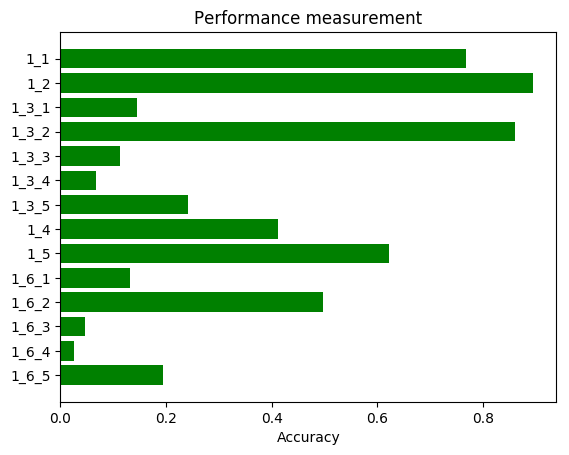

In [45]:
import matplotlib.pyplot as plt

performance_1 = [performance1_1, performance1_2, performance1_3_1,
                 performance1_3_2, performance1_3_3, performance1_3_4,
                 performance1_3_5, performance1_4, performance1_5,
                 performance1_6_1, performance1_6_2, performance1_6_3,
                 performance1_6_4, performance1_6_5]


fig, ax = plt.subplots()

# Example data
data = ('1_1', '1_2', '1_3_1', '1_3_2', '1_3_3', '1_3_4', '1_3_5', '1_4', '1_5', '1_6_1', '1_6_2', '1_6_3', '1_6_4', '1_6_5')
y_pos = np.arange(len(data))

ax.barh(y_pos, performance_1, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy')
ax.set_title('Performance measurement')

plt.show()

# Task 2
## Model 4
Before starting, we will define the feature extractor

#### Feature Extractor
In this section, we extract the feature of a words. 
The extracted features are :
1. Prefix
2. Suffix
3. Capitalize (bool)
4. Only first letter is capitalize (bool)
5. Previous Word
6. Next Word
7. The word has more than 3 letters (bool)

In [16]:
def features_id(sentence, index):
    # array of prefixes
    # http://indodic.com/affixeng.html
    prefixes = np.array([[],[],['di','ke','me','pe','se'],\
                         ['ber','mem','men','pem','pen','per','ter'],\
                         ['meng','meny','peng','peny'],\
                         ['menge','penge']])
    # checking for possible prefix
    has_prefix = False
    prefix_len = 0
    for i in range(5,1):
        if sentence[index][:i] in prefixes[i] and len(sentence[index]) != i:
            prefix_len = i
            has_prefix = True
            break
    
    # array of suffixes 
    # http://indodic.com/affixeng.html
    suffixes = np.array([[],['i'],['an'],\
                            ['kan','lah','kah','nya']])
    
    # checking for possible suffixes
    has_suffixes = False
    suffixes_len = -1
    for i in range(3,0):
        if sentence[index][-i:] in noun_suffixes[i] and len(sentence[index]) != i:
            suffixes_len = -i
            has_suffixes = True
            break
    # end of checking for possible suffixes
    
    return {
        'word': sentence[index],
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'first_letter_capitalized': sentence[index][0].title() == sentence[index][0],
        'has_prefix': has_prefix,
        'prefix': sentence[index][:prefix_len],
        'has_suffix': has_suffixes,
        'suffix': sentence[index][suffixes_len:] if has_suffixes else '',
        'more_than_3_letter': len(sentence[index]) > 3,
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1]
    }
import pprint 
pprint.pprint(features(['Mencoba','menjelaskan','kalimat','tidak','mungkin'], 1))

{'first_letter_capitalized': False,
 'has_adj_suffix': False,
 'has_noun_suffix': False,
 'has_prefix': False,
 'has_verb_suffix': False,
 'is_capitalized': False,
 'more_than_3_letter': True,
 'next_word': 'kalimat',
 'prefix': '',
 'prev_word': 'Mencoba',
 'suffix': 'n',
 'word': 'menjelaskan'}


## Pre-processing corpus X3

In [135]:
# Splitting tagged_sentence into [features] and [labels]
def transform_to_dataset_id(tagged_sentences):
    X, y = [], []
    for tagged in tagged_sentences:
        for index in range(len(tagged)):
            X.append(features_id(untag(tagged), index))
            y.append(tagged[index][1])
 
    return X, y

# setting data training and data test to 80% - 20%
cutoff = int(.8 * len(X3))
X3_training = X3[:cutoff]
X3_test = X3[cutoff:]

# x will contain features
# y will contain labels/tags
x3, y3 = transform_to_dataset(X3_training)
x3_test, y3_test = transform_to_dataset_id(X3_test)

x3_test_sents = X3_sents[cutoff:]

## Training

In [47]:
from sklearn.tree import DecisionTreeClassifier

size=10000

model4 = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', DecisionTreeClassifier(criterion='entropy'))])

model4.fit(x3[:size], y3[:size])
print("training ok")

training ok


## Performance2_1

In [49]:
performance2_1 = model4.score(x3_test, y3_test)
print("Accuracy:", performance2_1)

Accuracy: 0.624767801858


## Model 5

In [159]:
import os
os.environ['TREETAGGER'] = '/home/yonathan/Documents/treetag/cmd'

from treetagger import TreeTagger

x3_test_raw = ""
for i in x3_test_sents:
    for j in i:
        x3_test_raw+=j+" "
        
tt = TreeTagger(language='dutch')
prediction2_2 = np.delete(tt.tag(x3_test_raw), 2, 1)
prediction2_2 = np.delete(prediction2_2, 0, 1)

## Performance2_2 Model5 in X3

In [160]:
performance2_2 = np.mean(np.reshape(prediction2_2, -1) == np.array(y3_test))
print(performance2_2)

0.0


## Plotting Performance

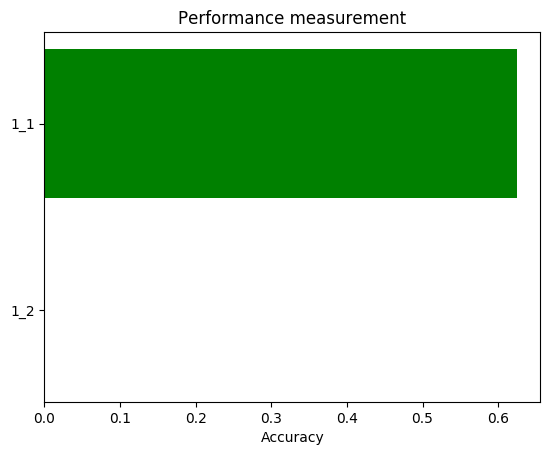

In [161]:
performance_2 = [performance2_1, performance2_2]


fig, ax = plt.subplots()

# Example data
data = ('2_1', '2_2')
y_pos = np.arange(len(data))

ax.barh(y_pos, performance_2, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accuracy')
ax.set_title('Performance measurement')

plt.show()